# <center>Анализ временных рядов в Python</center>
## <center>Часть 2. Смерти из-за несчастного случая в США</center>

Известно ежемесячное число смертей в результате случайного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [16]:
import warnings

from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.filterwarnings("ignore")

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = 12, 10
from itertools import product

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats


def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

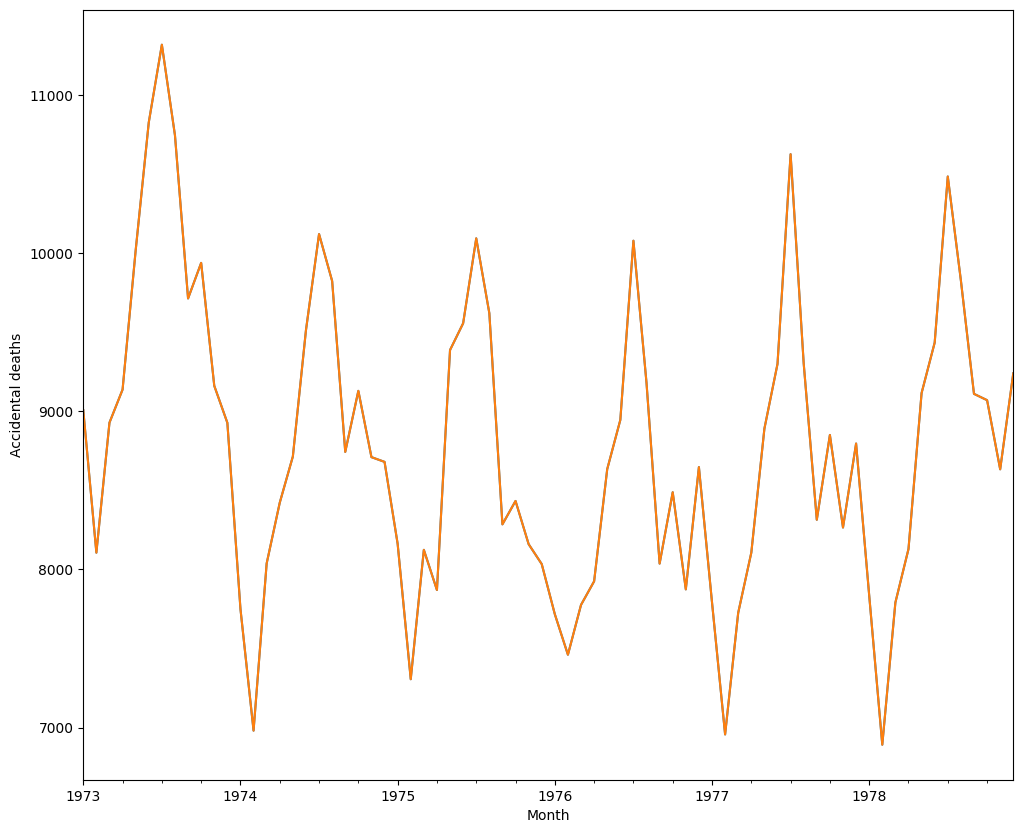

In [4]:
deaths = pd.read_csv(
    "accidental-deaths-in-usa-monthly.csv",
    index_col=["Month"],
    parse_dates=["Month"],
)
deaths.rename(
    columns={"Accidental deaths in USA: monthly, 1973 ? 1978": "num_deaths"},
    inplace=True,
)
deaths["num_deaths"].plot()
plt.ylabel("Accidental deaths")
plt.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.102481


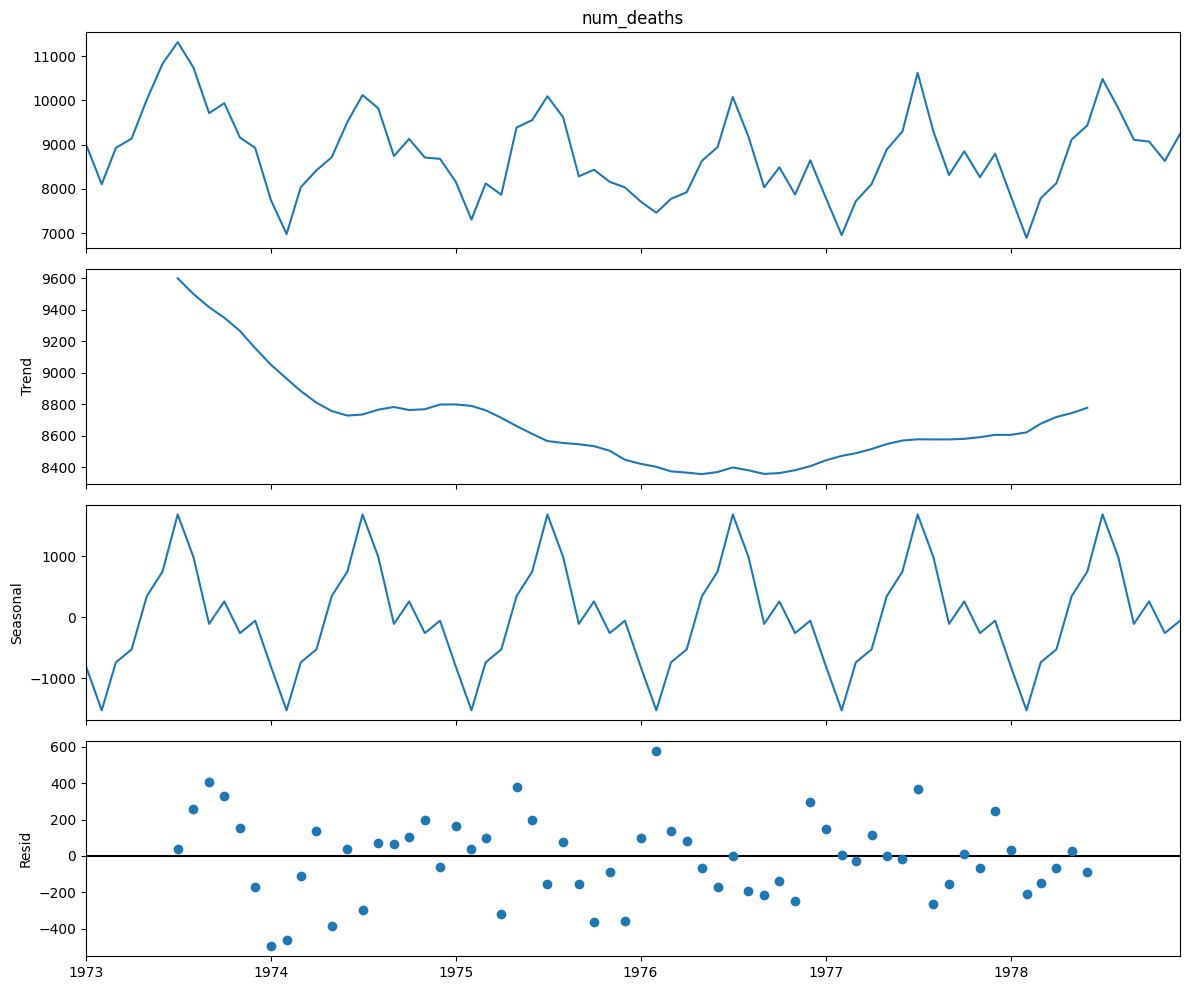

In [7]:
sm.tsa.seasonal_decompose(deaths["num_deaths"]).plot()
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths["num_deaths"])[1]
)
plt.show()

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, но небольшой тренд остался. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014650


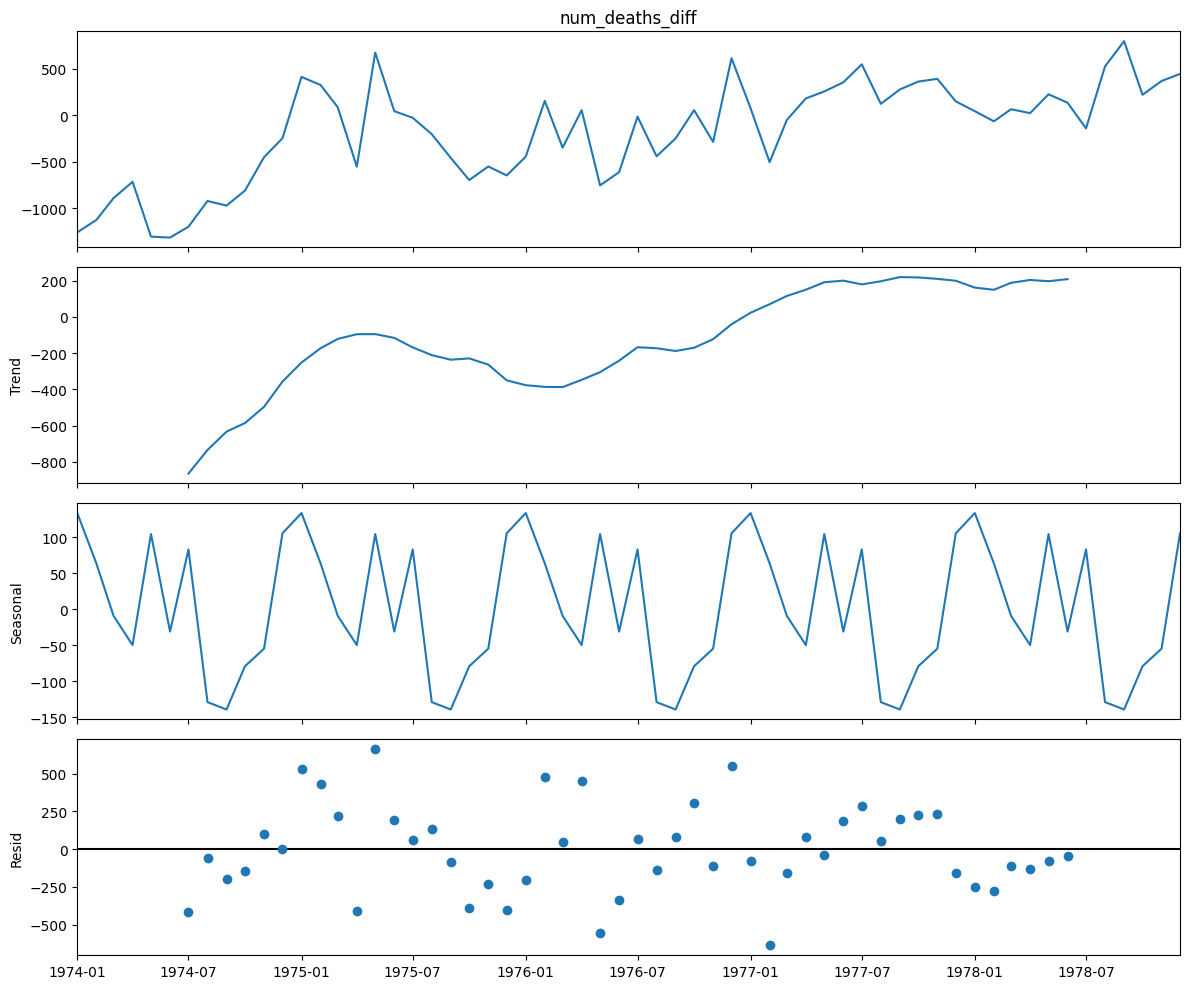

In [8]:
deaths["num_deaths_diff"] = deaths["num_deaths"] - deaths["num_deaths"].shift(12)
sm.tsa.seasonal_decompose(deaths["num_deaths_diff"][12:]).plot()
print(
    "Критерий Дики-Фуллера: p=%f"
    % sm.tsa.stattools.adfuller(deaths["num_deaths_diff"][12:])[1]
)
plt.show()

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


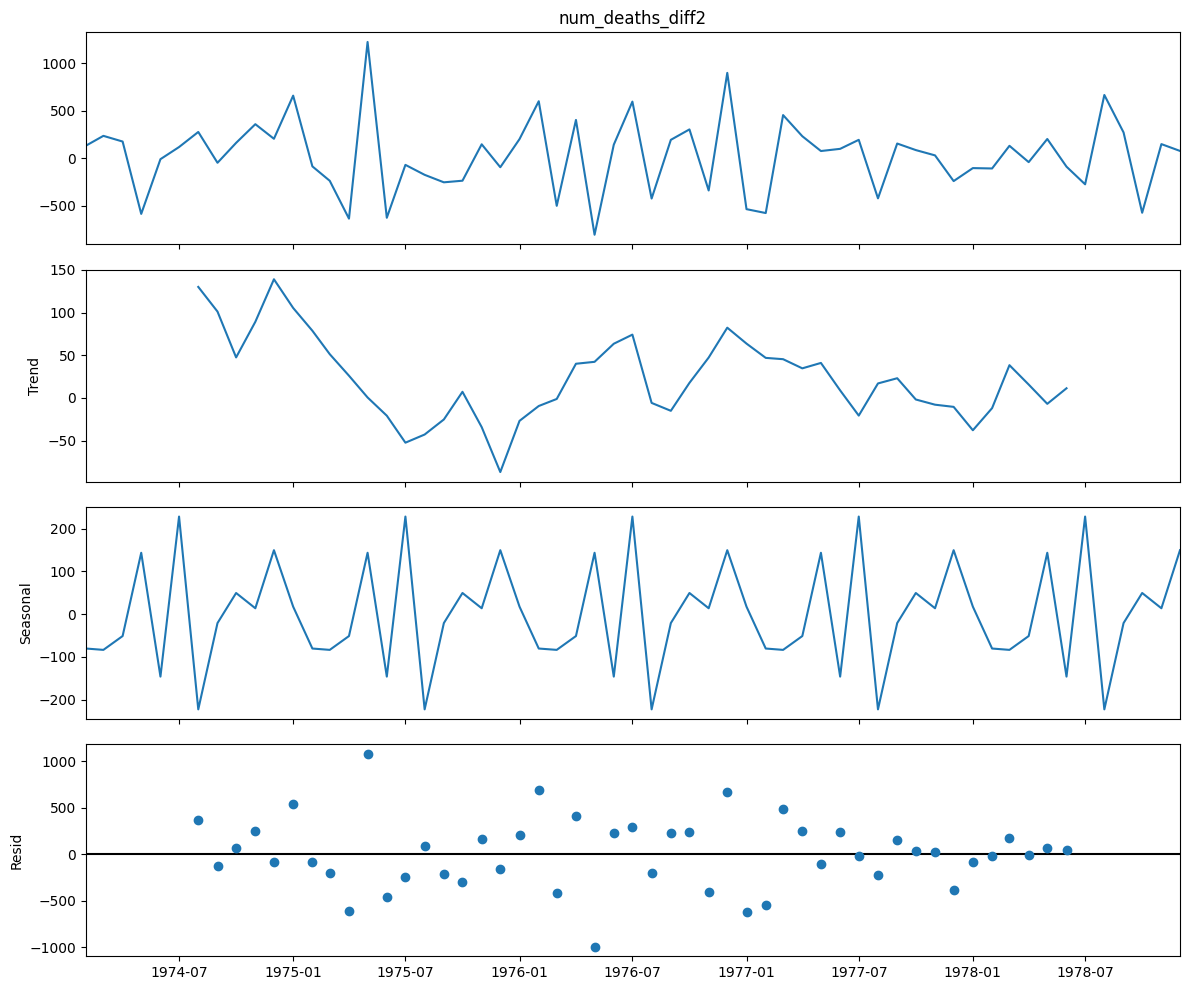

In [9]:
deaths["num_deaths_diff2"] = deaths["num_deaths_diff"] - deaths["num_deaths_diff"].shift(1)

sm.tsa.seasonal_decompose(deaths["num_deaths_diff2"][13:]).plot()
print(
    "Критерий Дики-Фуллера: p=%f"
    % sm.tsa.stattools.adfuller(deaths["num_deaths_diff2"][13:])[1]
)
plt.show()

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

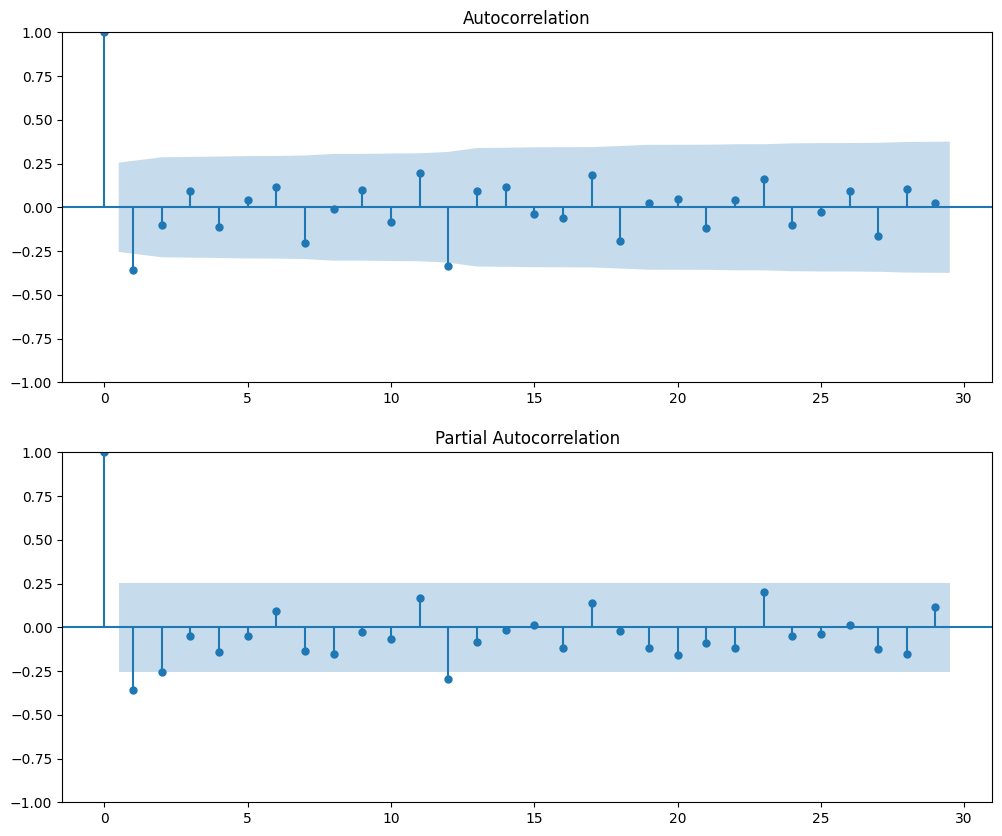

In [12]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(
    deaths["num_deaths_diff2"][13:].values.squeeze(), lags=29, ax=ax
)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    deaths["num_deaths_diff2"][13:].values.squeeze(), lags=29, ax=ax
)
plt.show()

In [13]:
ps = range(0, 3)
d = 1
qs = range(0, 1)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)

In [14]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [17]:
%%time
results = []
best_aic = float("inf")


for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            deaths["num_deaths"],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12),
        ).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings("default")

CPU times: user 3.26 s, sys: 28.3 ms, total: 3.29 s
Wall time: 3.29 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

      parameters         aic
19  (2, 0, 0, 1)  854.647098
10  (1, 0, 0, 1)  855.458079
24  (2, 0, 2, 0)  856.494101
20  (2, 0, 0, 2)  856.603171
22  (2, 0, 1, 1)  856.614483


Лучшая модель:

In [19]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           num_deaths   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -423.324
Date:                              Fri, 27 Sep 2024   AIC                            854.647
Time:                                      03:08:17   BIC                            862.957
Sample:                                  01-01-1973   HQIC                           857.891
                                       - 12-01-1978                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3724      0.112     -3.329      0.001      -0.592      -0.153
ar.L2         -0.19

Её остатки:

Критерий Стьюдента: p=0.274373
Критерий Дики-Фуллера: p=0.000000


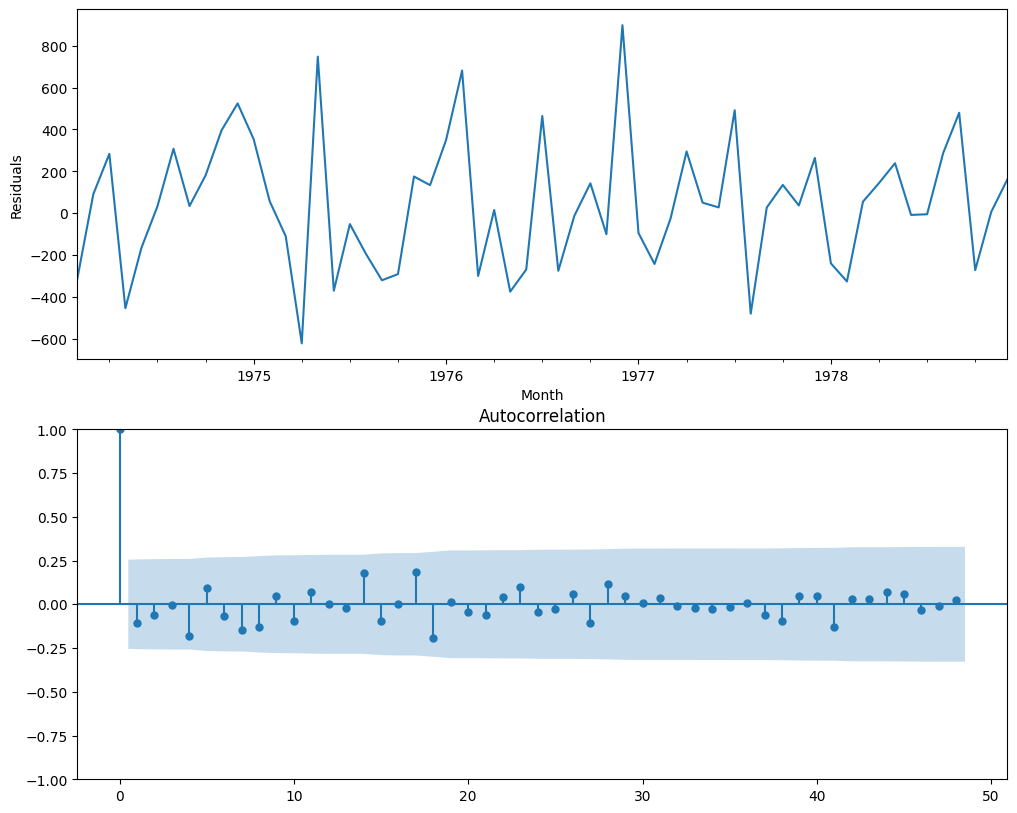

In [22]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]
)
plt.show()

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

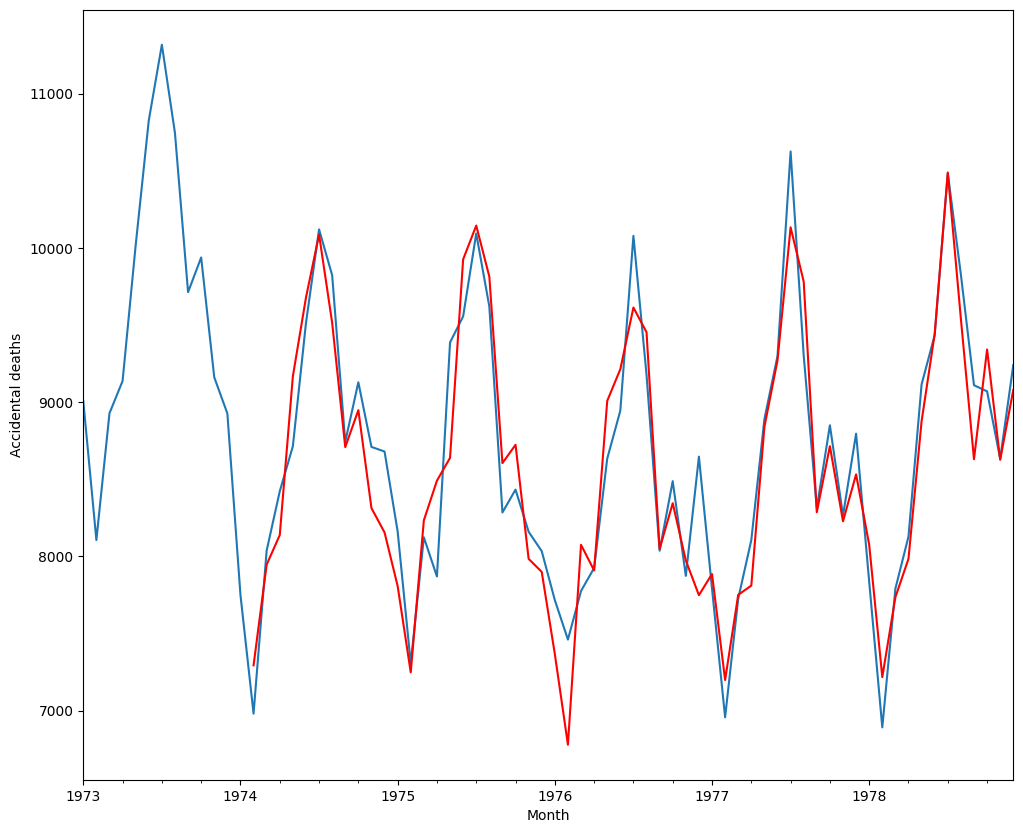

In [23]:
deaths["model"] = best_model.fittedvalues
deaths["num_deaths"].plot()
deaths["model"][13:].plot(color="r")
plt.ylabel("Accidental deaths")
plt.show()

### Прогноз

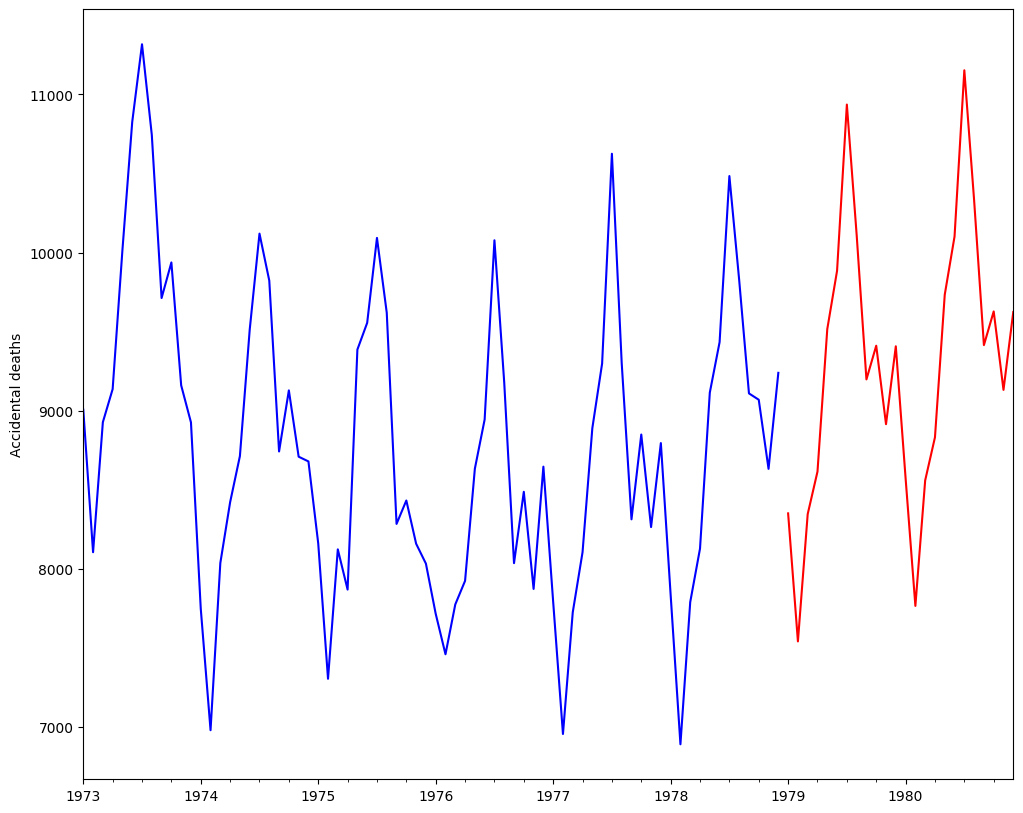

In [29]:
from dateutil.relativedelta import relativedelta

deaths2 = deaths[["num_deaths"]]
date_list = [
    pd.to_datetime('1979-01-01') + relativedelta(months=x)
    for x in range(0, 24)
]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2["forecast"] = best_model.predict(start=72, end=100)

deaths2["num_deaths"].plot(color="b")
deaths2["forecast"].plot(color="r")
plt.ylabel("Accidental deaths")
plt.show()

In [31]:
deaths

,num_deaths,num_deaths_diff,num_deaths_diff2,model
Month,,,,
1973-01-01,9007,NaN,NaN,0.000000
1973-02-01,8106,NaN,NaN,8823.426829
1973-03-01,8928,NaN,NaN,8086.458807
1973-04-01,9137,NaN,NaN,8955.774411
1973-05-01,10017,NaN,NaN,9103.728507
...,...,...,...,...
1978-08-01,9827,525.0,666.0,9540.021614
1978-09-01,9110,796.0,271.0,8630.213164
1978-10-01,9070,220.0,-576.0,9341.519802


# Заключение

Мы познакомились с разными методами и подходами к анализу и прогнозированию временных рядов. К сожалению, или к счастью, серебряной пули для решения такого рода задач пока не появилось. Методы, разработанные в 60-е годы прошлого века, (а некоторые и в начале 19-го), по-прежнему пользуются популярностью наравне с неразобранными в данного курса LSTM или RNN. Отчасти это связано с тем, что задача прогнозирования, как и любая другая задача, возникающая в процессе работы с данными - во многом творческая и уж точно исследовательская. Несмотря на обилие формальных метрик качества и способов оценки параметров, для каждого временного ряда часто приходится подбирать и пробовать что-то своё. Не последнюю роль играет и баланс между качеством и трудозатратами. Не раз уже упоминавшаяся здесь SARIMA-модель хотя и демонстрирует выдающиеся результаты при должной настройке, может потребовать не одного часа ~~танцев с бубном~~ манипуляций с рядом, в то время как простенькую линейную регрессию можно соорудить за 10 минут, получив при этом более-менее сравнимые результаты.